In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model, parse_simulated_data, get_data_filenames, add_sequence_columns

import utils.file_management as fm

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [22]:
run = 24

In [23]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print number of parameters and important metadata
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Using cpu device
Total number of parameters: 292


In [24]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

events = parse_simulated_data(*get_data_filenames(run, suffix='v'))
events = add_sequence_columns(events, T)
vc = events[f'seq{T}_RL'].value_counts()
sequences = vc[vc > 100].sample(n=20).index

Explained variance ratio: [8.4634477e-01 1.5249006e-01 1.1650638e-03 1.0407136e-15]
Cumulative explained variance: [0.84634477 0.99883485 0.99999994 0.99999994]


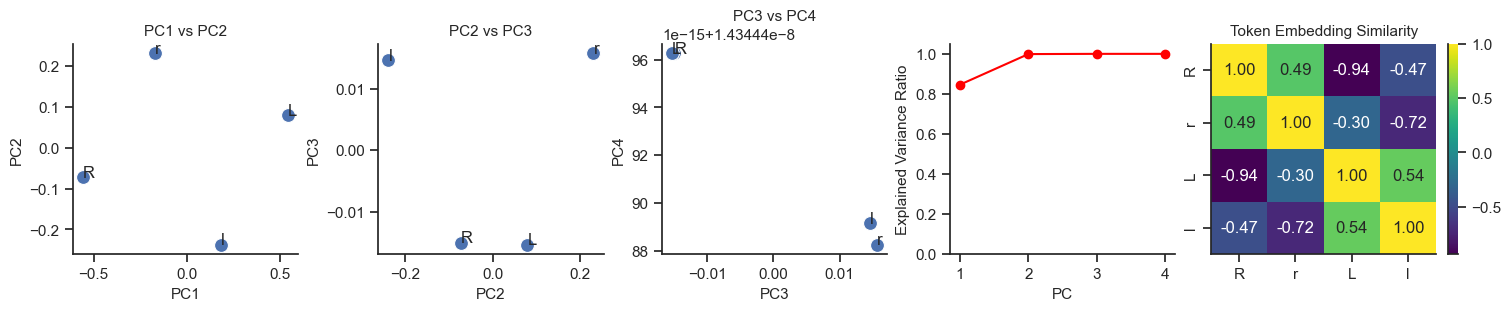

In [25]:
def token_embedding_similarity(model, vocab_mappings, ax=None):
    """
    Analyze the token embeddings from the input embedding layer (model.transformer.wte).
    
    Parameters:
    -----------
    model : transformer model
        The trained transformer model
    vocab : list or dict
        Vocabulary list or dictionary mapping tokens to indices

    Returns:
    --------
    embeddings : numpy.ndarray
        The token embedding matrix
    similarity_matrix : numpy.ndarray
        Matrix of cosine similarities between token embeddings
    """
    # Extract the token embedding matrix
    token_embeddings = model.transformer.wte.weight.detach().cpu().numpy()
    
    # Compute cosine similarity between token embeddings
    similarity_matrix = cosine_similarity(token_embeddings)
    
    # Plot the token embedding similarity matrix
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt='.2f',
        cmap='viridis',
        xticklabels=vocab_mappings.keys(),
        yticklabels=vocab_mappings.keys(),
        ax=ax
    )
    plt.title('Token Embedding Similarity')
    
    return token_embeddings, similarity_matrix


def pca_embeddings(model, n_components=2, token_mapping=None):
    """
    Perform PCA on model's token embeddings and visualize them.
    
    Parameters:
    -----------
    model : transformer model
        The model containing token embeddings
    n_components : int, default=2
        Number of PCA components to extract
    token_labels : list, optional
        Labels for each token in the vocabulary
    
    Returns:
    --------
    pca : sklearn.decomposition.PCA
        Fitted PCA model
    embedded : numpy.ndarray
        Embeddings transformed to the PCA space
    """
    # Extract token embeddings
    embeddings = model.transformer.wte.weight.detach().cpu().numpy()
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    embedded = pca.fit_transform(embeddings)
    
    # Create default token labels if not provided
    if token_mapping is None:
        token_mapping = {i: f"Token {i}" for i in range(embeddings.shape[0])}
    
    n_plots = n_components + 1
    fig, axs = plt.subplots(ncols=n_plots, figsize=(n_plots*3, 3), layout='constrained')
    
    if n_plots == 1:
        axes = [axes]
    # Create DataFrame for easy plotting
    df = pd.DataFrame({
        f'PC{i+1}': embedded[:, i] for i in range(n_components)
    } | {'Token': token_mapping.keys()})
    
    for i, ax in enumerate(axs[:-2], start=1):
        sns.scatterplot(x=f'PC{i}', y=f'PC{i+1}', data=df, ax=ax, s=100)
        for j, txt in enumerate(token_mapping.keys()):
            ax.annotate(txt, (df[f'PC{i}'][j], df[f'PC{i+1}'][j]), fontsize=12)
        ax.set(title=f"PC{i} vs PC{i+1}")
    
    # Analyze explained variance
    axs[-2].plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', color='red')
    axs[-2].set(xlabel='PC',
           ylabel='Explained Variance Ratio',
           xticks=range(1, n_components + 1),
           ylim=(0, 1.05)
           )

    embeddings, similarities = token_embedding_similarity(model, token_mapping, ax=axs[-1])

    sns.despine()
    
    return pca, embedded

# Example usage with your model:
pca, embedded = pca_embeddings(
    model, 
    n_components=4,
    token_mapping=stoi
)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

<Axes: >

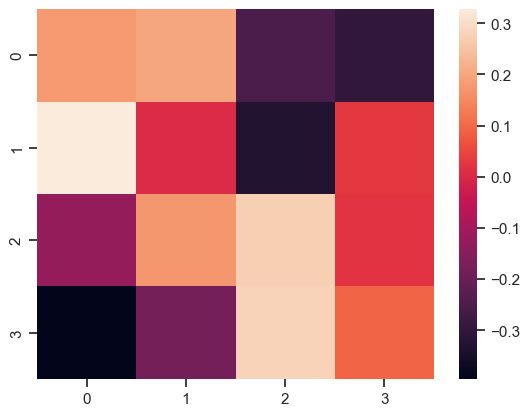

In [26]:
sns.heatmap(model.transformer.wte.weight.detach().cpu().numpy().T)

<Axes: >

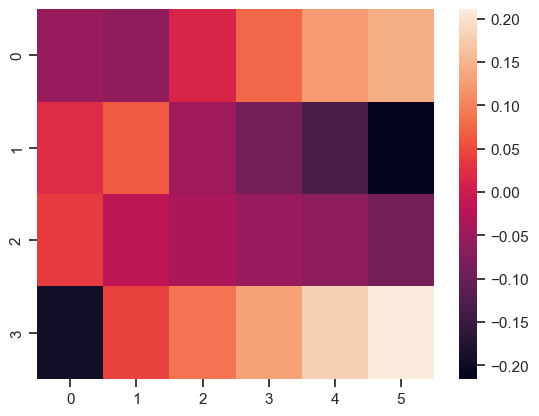

In [27]:
sns.heatmap(model.transformer.wpe.weight.detach().cpu().numpy().T)

In [28]:
def sequence_embedding_similarity(model, sequences, stoi):
    """
    Analyze sequences as they would actually be encoded for the attention layers,
    including positional embeddings and proper concatenation.
    
    Parameters:
    -----------
    model : transformer model
        The trained transformer model
    sequences : list of str
        List of sequences to analyze
    stoi : dict
        Mapping from tokens to indices
        
    Returns:
    --------
    sequence_embeddings : numpy.ndarray
        Array of sequence embeddings with positional information
    similarity_matrix : numpy.ndarray
        Matrix of cosine similarities between sequence embeddings
    """
    # Get the full embeddings as they're processed by the model
    sequence_embeddings = []
    
    for sequence in sequences:
        # Get indices for tokens in the sequence
        token_indices = [stoi[char] for char in sequence]
        
        # Convert to tensor
        input_tensor = torch.tensor(token_indices, dtype=torch.long).unsqueeze(0).to(model.device)
        
        # Get position indices (0, 1, 2, ...)
        pos = torch.arange(0, len(token_indices), dtype=torch.long, device=input_tensor.device)
        
        # Get token embeddings and positional embeddings (exactly as in model.forward)
        token_embeddings = model.transformer.wte(input_tensor)
        pos_embeddings = model.transformer.wpe(pos)
        
        # Combine token and positional embeddings (exactly as the model does)
        combined_embeddings = token_embeddings + pos_embeddings
        
        # Flatten to get a single vector representation of the entire sequence
        flat_embedding = combined_embeddings.squeeze(0).flatten().detach().cpu().numpy()
        sequence_embeddings.append(flat_embedding)
    
    sequence_embeddings = np.array(sequence_embeddings)
    
    # Compute similarity matrix
    similarity_matrix = cosine_similarity(sequence_embeddings)
    
    return sequence_embeddings, similarity_matrix

In [29]:
def cluster_sequences_hierarchical(similarity_matrix, sequences, method='ward', metric='euclidean'):
    """
    Perform hierarchical clustering with optimal leaf ordering.
    
    Parameters:
    -----------
    similarity_matrix : numpy.ndarray
        Matrix of similarities between sequences
    sequences : list of str
        List of sequences 
    method : str, default='ward'
        Linkage method: 'ward', 'complete', 'average', or 'single'
    metric : str, default='euclidean'
        Distance metric (use 'precomputed' if similarity_matrix is a distance matrix)
    """
    from scipy.cluster.hierarchy import linkage, dendrogram, optimal_leaf_ordering
    
    # Convert similarity to distance if needed (distance = 1 - similarity)
    if metric != 'precomputed':
        distance_matrix = 1 - similarity_matrix
    else:
        distance_matrix = similarity_matrix
        
    # Compute linkage matrix
    Z = linkage(distance_matrix, method=method)
    
    # Apply optimal leaf ordering to get a better visualization
    Z_ordered = optimal_leaf_ordering(Z, distance_matrix)
    
    # Plot dendrogram
    fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
    dendrogram(
        Z_ordered,
        labels=sequences,
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=0.7*np.max(Z_ordered[:,2]),  # Threshold for coloring branches
        ax=ax
    )
    ax.set(title=f'Hierarchical Clustering ({method} linkage)')
    
    # Get the optimal ordering of sequences
    ordered_indices = dendrogram(Z_ordered, no_plot=True)['leaves']
    ordered_sequences = [sequences[i] for i in ordered_indices]
    
    # Reorder similarity matrix according to this ordering
    ordered_sim_matrix = similarity_matrix[ordered_indices][:, ordered_indices]
    
    # Plot reordered similarity matrix
    fig, ax = plt.subplots(figsize=(0.4 * len(sequences), 0.4 * len(sequences)), layout='constrained')
    sns.heatmap(
        ordered_sim_matrix,
        cmap='viridis',
        xticklabels=ordered_sequences,
        yticklabels=ordered_sequences,
        ax=ax
    )
    ax.set(title='Similarity Matrix (Ordered by Hierarchical Clustering)')
    
    return ordered_sequences, ordered_sim_matrix, Z_ordered

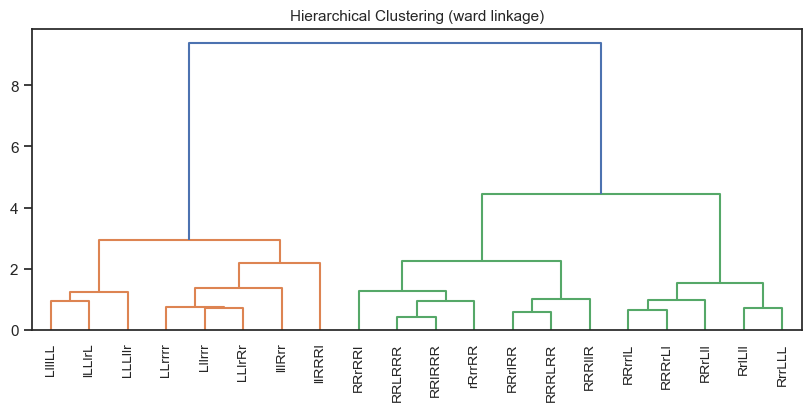

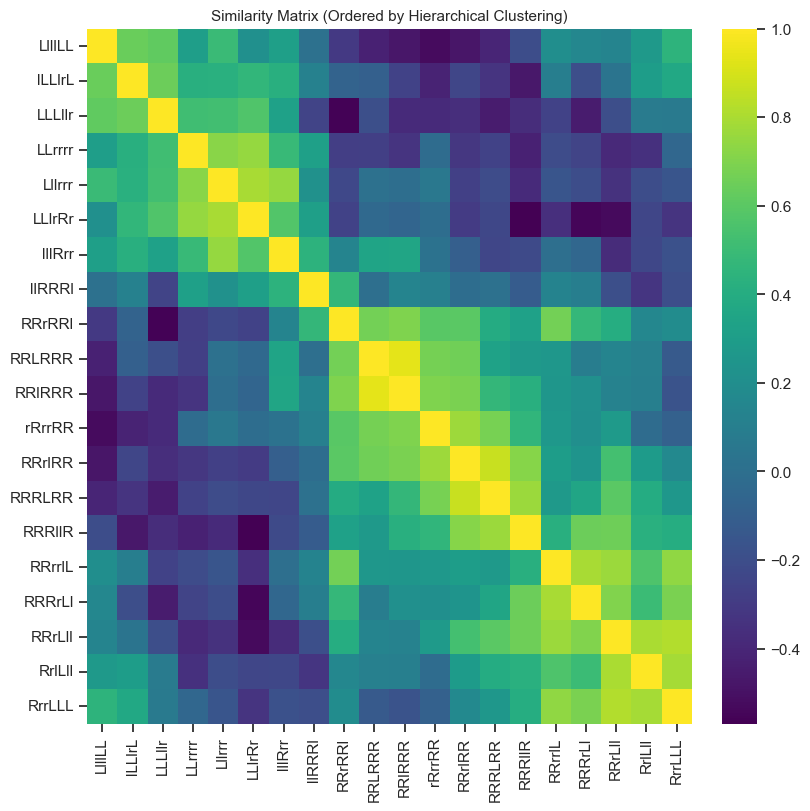

In [32]:
embeddings, similarities = sequence_embedding_similarity(model, sequences, stoi)

ordered_sequences, ordered_sim_matrix, Z_ordered = cluster_sequences_hierarchical(similarities, sequences)

In [139]:
sys.path.append(os.path.abspath('../'))
from utils.checkpoint_processing import process_checkpoints, add_checkpoint_colorbar

def extract_token_embeddings(model):
    """Extract token embedding weights from a model."""
    return model.transformer.wte.weight.detach().cpu().numpy()

def embedding_processor(model, checkpoint_num, is_reference, **kwargs):
    """Process a model to extract its token embeddings."""
    embeddings = extract_token_embeddings(model)
    return embeddings

def analyze_embedding_evolution(run, reference_type='final', save_results=False):
    """
    Analyze the evolution of token embeddings across checkpoints.
    
    Parameters:
    -----------
    run : int
        Run number
    reference_type : str, default='final'
        Type of reference model to use ('final' or 'first')
    save_results : bool, default=False
        Whether to save visualizations and data to disk
    """
    # Process all checkpoints to extract embeddings
    checkpoint_data = process_checkpoints(
        run=run,
        processor_fn=embedding_processor,
        reference_type=reference_type,
        save_results=save_results
    )
    
    if not checkpoint_data:
        return
    
    all_embeddings = checkpoint_data['results']
    checkpoint_numbers = checkpoint_data['checkpoint_numbers']
    model_labels = checkpoint_data['model_labels']
    reference_idx = checkpoint_data['reference_idx']
    
    # Get reference embeddings
    reference_embeddings = all_embeddings[reference_idx]
    
    # Fit PCA on reference embeddings
    pca = PCA(n_components=2)
    pca.fit(reference_embeddings)
    
    # Project all embeddings using the same PCA
    projected_embeddings = [pca.transform(emb) for emb in all_embeddings]
    
    # Create visualization
    plot_embedding_evolution(projected_embeddings, model_labels, checkpoint_numbers, 
                           reference_idx, run, save_results)
    
    # Calculate distances from reference
    calculate_embedding_distances(all_embeddings, checkpoint_numbers, model_labels, 
                               reference_idx, run, save_results)
    
    return projected_embeddings

def plot_embedding_evolution(projected_embeddings, model_labels, checkpoint_numbers, 
                           reference_idx, run, save_results=False):
    """Visualize the evolution of embeddings in 2D space."""

    n_tokens = projected_embeddings[0].shape[0]
    
    fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
    cmap = {label: color
            for label, color in zip(model_labels, sns.color_palette('viridis', len(model_labels)))
            if not 'final' in label}
    cmap['final'] = 'red'

    for token_idx in range(n_tokens):
        # Get embeddings for this token across all checkpoints
        token_positions = np.array([emb[token_idx] for emb in projected_embeddings])
        
        token_positions = pd.DataFrame(token_positions, columns=['PC1', 'PC2'])
        token_positions['model'] = model_labels
        sns.scatterplot(x='PC1', y='PC2', data=token_positions, palette=cmap, 
                      s=60, marker='o', ax=ax, hue='model',
                      edgecolor=None)

        ax.text(token_positions.query('model=="final"')['PC1'].item(),
                token_positions.query('model=="final"')['PC2'].item(), 
                str(itos[token_idx]), 
                fontsize=8, ha='center', va='center', zorder=len(model_labels)+1)
    
    ax.set(xlabel='PC 1',
           ylabel='PC 2',
           title=f'Token Embeddings Across Training')

    add_checkpoint_colorbar(fig, ax, cmap, ground_truth=False,
                            colorbar_kwargs = {'shrink': 0.8, 'pad': 0.02, 'location': 'right'})
    
    sns.despine()
    
    if save_results:
        out_path = fm.get_experiment_file(f'token_embedding_evolution.png', run, subdir='predictions')
        plt.savefig(out_path, bbox_inches='tight', dpi=300)

def calculate_embedding_distances(all_embeddings, checkpoint_numbers, model_labels, 
                               reference_idx, run, save_results=False):
    """Calculate distances between embeddings across checkpoints."""
    reference_embeddings = all_embeddings[reference_idx]
    
    cos_sims = []
    eucl_dists = []
    
    for embeddings in all_embeddings:
        # Average cosine similarity across all tokens
        cos_sim = np.mean([
            np.dot(embeddings[i], reference_embeddings[i]) / 
            (np.linalg.norm(embeddings[i]) * np.linalg.norm(reference_embeddings[i]))
            for i in range(len(embeddings))
        ])
        cos_sims.append(cos_sim)
        
        # Average Euclidean distance across all tokens
        eucl_dist = np.mean([
            np.linalg.norm(embeddings[i] - reference_embeddings[i])
            for i in range(len(embeddings))
        ])
        eucl_dists.append(eucl_dist)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Checkpoint': checkpoint_numbers,
        'Model': model_labels,
        'Cosine Similarity': cos_sims,
        'Euclidean Distance': eucl_dists
    })
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 3.5), sharex=True, layout='constrained')
    
    plot_df = df[df.index != reference_idx]
    
    sns.lineplot(data=plot_df, x='Checkpoint', y='Cosine Similarity', ax=ax1, marker='o', color='k')
    ax1.set(ylabel='Cosine\nSimilarity',
            title=f'Embedding Similarity\nto Reference Model')
    
    sns.lineplot(data=plot_df, x='Checkpoint', y='Euclidean Distance', ax=ax2, marker='o', color='k')
    ax2.set(ylabel='Euclidean\nDistance',
            xlabel='Checkpoint')
    sns.despine()

    if save_results:
        out_path = fm.get_experiment_file(f'token_embedding_distances.png', run, subdir='predictions')
        plt.savefig(out_path, bbox_inches='tight', dpi=300)

Found 11 models for run 24


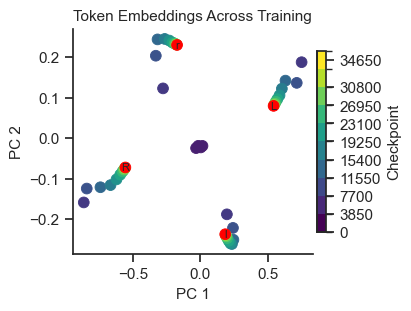

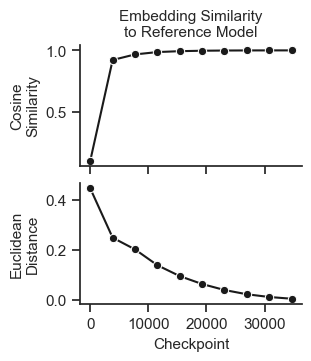

In [141]:
cp_data = analyze_embedding_evolution(run)